# GreEn-ER consumption : from raw data to first forecasts 

## Objectives

- propose your own pipeline to predict the GreEn-ER electricity consumption on the basis of consumption history, weather data, or the opening of the building.
- several tasks may be addressed: e.g. prediction at 1 hour, 1 day, 3 days, ...  horizon. Or the prediction of different items of electricity consumption (rather than the global one).
- you can elaborate on this notebook to derive and optimize your pipeline 

In [1]:
import scipy as sp
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
# How to display figures (change to '%matplotlib widget' for interactive plots)
%matplotlib inline

In [2]:
def loadData(fileName):
    return pd.read_csv(fileName, index_col=0, parse_dates=True, dtype='float32')

In [3]:
# In which folder are the data files ?
data_folder = Path('data')
# Uncomment the next line is the data files .rds are in the current folder
#data_folder = Path('.')
csvFile = data_folder / 'conso_globale.csv'
df = loadData(csvFile)

## Quick preprocessing

### Missing values

#### Temperatures

In [4]:
# Impute missing values with nearest neighbors
it_na = np.where(df['Temperature'].isna())[0]
temp_impute = df['Temperature'].fillna(method='bfill')
# Is there any missing values ?
np.any(temp_impute.isna())

False

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


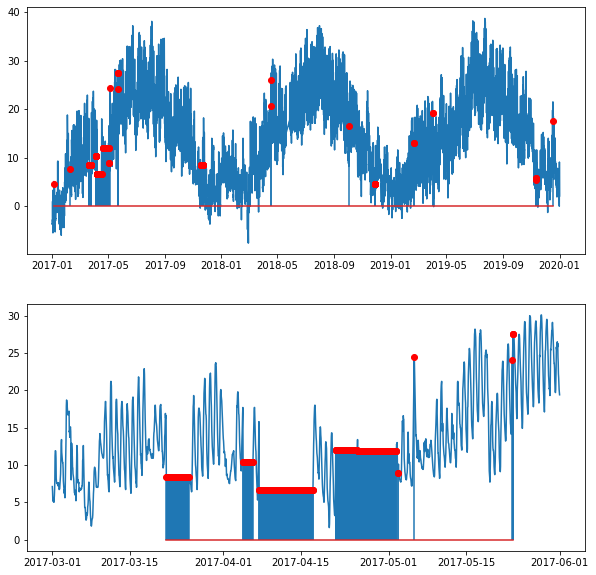

In [5]:
plt.subplots(2,1,figsize=(10,10) )
plt.subplot(2,1,1)
plt.plot(temp_impute)
#temp_impute[i_na].plot(subplots=True,color='r')
plt.stem(np.asarray(temp_impute[it_na].index,dtype=object),temp_impute[it_na].values,markerfmt='ro',use_line_collection=True)

#zoom on 2017
plt.subplot(2,1,2)
# Create variable  with data from "2017-03-01" to "2017-05-31"
year2017 = temp_impute["2017-03-01":"2017-05-31"]
it_na_2017 = np.where(df['Temperature']["2017-03-01":"2017-05-31"].isna())[0]
plt.plot(year2017)
plt.stem(np.asarray(year2017[it_na_2017].index,dtype=object),year2017[it_na_2017].values,markerfmt='ro',use_line_collection=True)
plt.show()

Observe that there are many missing values for the temperature in 2017. Should be imputed in a more accurate way...

#### Global consumption

In [6]:
# Impute missing values with nearest neighbors
ic_na = np.where(df['Global Consumption'].isna())[0]
conso_impute = df['Global Consumption'].fillna(method='bfill')
# Is there any missing values ?
np.any(conso_impute.isna())

False

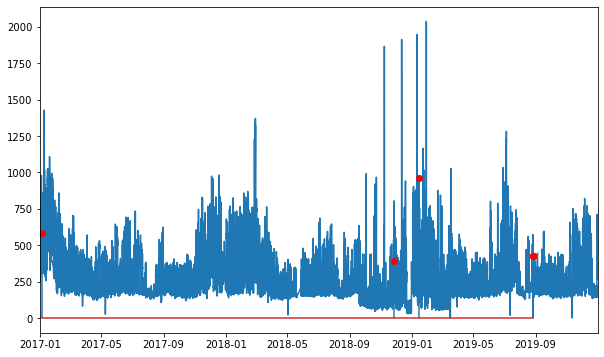

In [7]:
plt.figure(figsize=(10,6))
conso_impute.plot(subplots=True)
#temp_impute[i_na].plot(subplots=True,color='r')
plt.stem(np.asarray(conso_impute[ic_na].index,dtype=object),conso_impute[ic_na],markerfmt='ro',use_line_collection=True)
plt.show()

### Missing samples

In [8]:
# Check if there is missing time samples (missing time instants in the regular time sampling)
diff = conso_impute.index -  conso_impute.index[0]
hours = ( diff.seconds // (3600) + diff.days*24 )
diff_hours = hours[1:] - hours[:-1]
time_gaps = np.where(diff_hours != 1)[0]
print('WARNING! Missing samples:\n{}'.format(conso_impute.index[time_gaps]))

WARNING! Missing samples:
DatetimeIndex([       '2018-05-20 23:00:00+00:00',
                      '2019-11-11 20:00:00+00:00',
                      '2019-11-11 21:00:00+00:00',
               '2019-11-11 21:49:33.333000+00:00'],
              dtype='datetime64[ns, UTC]', freq=None)


<StemContainer object of 3 artists>

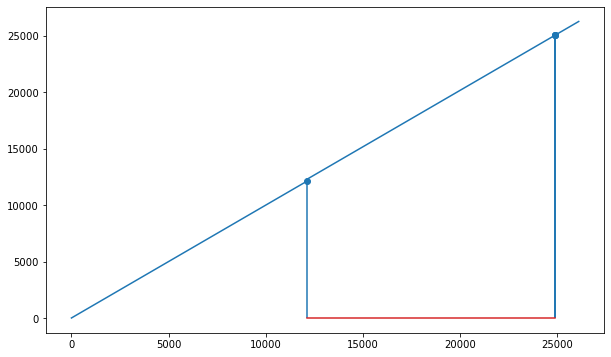

In [9]:
plt.figure(figsize=(10,6))
plt.plot(np.asarray(hours,dtype=object))
xstem= np.arange(len(hours))
plt.stem(xstem[time_gaps],hours[time_gaps], use_line_collection=True)

**FIXME** There are missing samples, especially a large gap from `2018-05-20 23:00:00` to `2018-05-31 8:00:00` (more than 10 days). Should be fixed (e.g. nearest neighbors for isolated gap, or using templates for larger gaps)

## Reshape the data to build predictors

### Option 1 : Include as predictors ALL the past hours for a given depth of history

#### Set the forecasting problem parameters

In [10]:
#conso_impute = conso_impute.to_numpy()
nsample = len(conso_impute)

# Take past value at time H-history
num_days = 7 # number of days
history = num_days*24 + 1 # D days of hourly measures (from day D, hour H to day D-7 hour H included)
# note that $history-1$ is now the offset index to get CURRENT time instant!

# Predict at time H+forecast
forecast = 24 # 24 h = 1 day ahead forecasting

#### Reshape the data

In [11]:
# Take consumption at time H+forecast 
ya_target = conso_impute[history+forecast-1:]

# Take temperatures at time H  (+ possibly past values)
xa_temp = temp_impute[history-1:nsample-forecast]

# Take past consumption values
Xa = np.zeros( shape=(nsample-forecast-history+1, history) ) 
for h in range(nsample-forecast-history+1):
    # Take past values
    Xa[h,:] = conso_impute[h:h+history]    

# Flip the predictor variables to get the current value as first column
Xa = np.fliplr(Xa)  
    
# Add current temperature as a feature (cat at the last column of X)
Xa = np.concatenate( (Xa, xa_temp.to_numpy().reshape(-1, 1) ) ,axis = 1  )

print(Xa.shape)
ya_target.shape

(25923, 170)


(25923,)

In [12]:
# Check that the X,y data are correctly time registered
print('starting time')
print('{} (x_temp)'.format(xa_temp.index[0]))
print('{} (current predictor X)'.format(conso_impute[0:0+history].index[-1]))
print('{} (last predictor X)'.format(conso_impute[0:0+history].index[0]))
print('{} (target y)'.format(ya_target.index[0]))

print('ending time')
print('{} (x_temp)'.format(xa_temp.index[-1]))
print('{} (current predictor X)'.format(
    conso_impute[(nsample-forecast-history):(nsample-forecast-history)+history].index[-1]))
print('{} (last predictor X)'.format(
    conso_impute[(nsample-forecast-history):(nsample-forecast-history)+history].index[0]))
print('{} (target y)'.format(ya_target.index[-1]))

starting time
2017-01-08 00:00:00+00:00 (x_temp)
2017-01-08 00:00:00+00:00 (current predictor X)
2017-01-01 00:00:00+00:00 (last predictor X)
2017-01-09 00:00:00+00:00 (target y)
ending time
2019-12-30 23:00:00+00:00 (x_temp)
2019-12-30 23:00:00+00:00 (current predictor X)
2019-12-23 23:00:00+00:00 (last predictor X)
2019-12-31 23:00:00+00:00 (target y)


### Option 2:  Include ONLY the *daily* past values at the *same* hour than the target

In [13]:
nsample = len(conso_impute)

# Take past value at time $D - history$ (in days)
history = 7 # one week of measure (in days)
# note that $history*24-1$ is now the offset index to get current time instant!

# Predict at time D+forecast (in day)
forecast = 1 # one day

offset = forecast*24+ (history-1)*24 # in samples (hours)

# Take consumption at time H+forecast 
yh_target = conso_impute[offset:]

# Take temperatures at time H  (+ possibly past values)
xh_temp = temp_impute[(history-1)*24:nsample-forecast*24]

# Take past consumption values per day (same hour)
Xh = np.zeros( shape=(nsample-offset,history) ) # past values 
for h in range(nsample-offset):
    # Take past values
    Xh[h,:] = conso_impute[h:h+history*24:24]

# Flip the predictor variables to get the current value as first column
Xh = np.fliplr(Xh)
    
# Add current temperature as a feature (cat at the last column of X)
Xh = np.concatenate( (Xh, xh_temp.to_numpy().reshape(-1, 1) ) ,axis = 1  )

Xh.shape

(25947, 8)

In [14]:
# Check that the X,y data are correctly registered
print('starting time')
print('{} (x_temp)'.format(xh_temp.index[0]))
print('{} (current predictor X)'.format(conso_impute[0:0+history*24:24].index[-1]))
print('{} (last predictor X)'.format(conso_impute[0:0+history*24:24].index[0]))
print('{} (target y)'.format(yh_target.index[0]))

print('ending time')
print('{} (x_temp)'.format(xh_temp.index[-1]))
print('{} (current predictor X)'.format(
    conso_impute[(nsample-offset-1):(nsample-offset-1)+history*24:24].index[-1]))
print('{} (last predictor X)'.format(
    conso_impute[(nsample-offset-1):(nsample-offset-1)+history*24:24].index[0]))
print('{} (target y)'.format(yh_target.index[-1]))

starting time
2017-01-07 00:00:00+00:00 (x_temp)
2017-01-07 00:00:00+00:00 (current predictor X)
2017-01-01 00:00:00+00:00 (last predictor X)
2017-01-08 00:00:00+00:00 (target y)
ending time
2019-12-30 23:00:00+00:00 (x_temp)
2019-12-30 23:00:00+00:00 (current predictor X)
2019-12-24 23:00:00+00:00 (last predictor X)
2019-12-31 23:00:00+00:00 (target y)


### Option 3:  Include ONLY a fixed day of the week, say wednesday, as target 

In [15]:
import datetime
todayname = datetime.datetime.today().strftime("%A")
weekdaynumber = datetime.datetime.today().weekday()
print('today ({}) is day number {}'.format(todayname,weekdaynumber))

# Get the wednesday (weekday number 2) samples
iweekday = np.where(ya_target.index.weekday.to_numpy() == 2 )[0]
Xd = Xa[iweekday,:] 
yd_target = ya_target[iweekday]
yd_target.shape

# Check that the X,y data are correctly registered
print('starting time')
print('{} (target y)'.format(yd_target.index[0]))
print('ending time')
print('{} (target y)'.format(yd_target.index[-1]))
print('10 first days')
print(yd_target.index[0:10*24:24])

today (Sunday) is day number 6
starting time
2017-01-11 00:00:00+00:00 (target y)
ending time
2019-12-25 23:00:00+00:00 (target y)
10 first days
DatetimeIndex(['2017-01-11 00:00:00+00:00', '2017-01-18 00:00:00+00:00',
               '2017-01-25 00:00:00+00:00', '2017-02-01 00:00:00+00:00',
               '2017-02-08 00:00:00+00:00', '2017-02-15 00:00:00+00:00',
               '2017-02-22 00:00:00+00:00', '2017-03-01 00:00:00+00:00',
               '2017-03-08 00:00:00+00:00', '2017-03-15 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq=None)


### Option 4: mix different strategies as you want!

In [16]:
#TODO, e.g. variable selection to retain only the most significant variables

Note that if your are comfortable with `datetime` and `pandas.Series` object, it may be a bit easier and less prone to failure to use directly the `DatetimeIndex` and enumerates on date directly (`for date in y.index`), using `timedelta` to get forecast target date/value (`y[forecast_date]` with `forecast_date = date + timedelta(horizon)`) and data past date/value (e.g. using `pandas.date_range()`). Anyway be careful with missing date/samples when filling the data matrix X

## Apply machine learning tools to forecast 

### Preprocess the data (continuated) : scaling

In [17]:
from sklearn.preprocessing import StandardScaler

# Scale (standardize) the data
sc = StandardScaler()
Xa_s= sc.fit_transform(Xa)
Xh_s= sc.fit_transform(Xh)

### Nearest neighbors regression

In [18]:
from sklearn.neighbors import KNeighborsRegressor

# D+1 forecasting with daily measurements from one week backward
X = Xh_s
y = yh_target

# always the same code ('fit' and 'predict'), whatever the method/model 
nn_h = KNeighborsRegressor(n_neighbors=51)
nn_h.fit(X, y)
y_nn_h = nn_h.predict(X)

### Display forecast

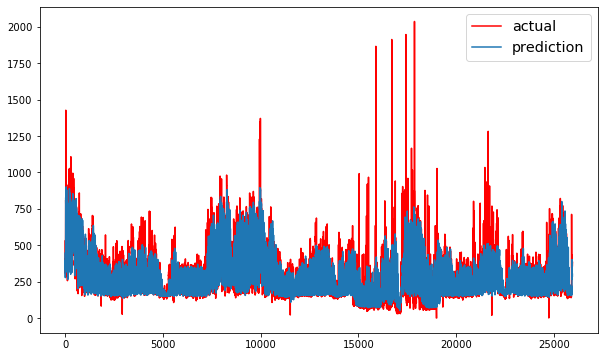

In [19]:
plt.figure(figsize=(10,6))
plt.plot(yh_target.values,'r')
plt.plot(y_nn_h)
plt.legend(['actual','prediction'], fontsize="x-large")
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score

# note that we can introduce weights to mitigate/remove extreme value
r2_train = r2_score(y_nn_h,y)
mad_train = median_absolute_error(y_nn_h,y)
print('training error r2 = {}, MAD = {}'.format(r2_train,mad_train) )

training error r2 = 0.7358367554625256, MAD = 22.323532104492188


### Cross-validate the parameters

In [21]:
# Create KGroupFold split with one group per year (for instance)
# Better than default KFold cross-validation that will randomly 
# split contiguous time instants (thus very correlated  values) 
# in train and test groups

from sklearn.model_selection import LeaveOneGroupOut

groups = np.zeros( y.shape)
years = y.index.year.to_numpy()
for iy , year in enumerate(np.arange( years.min(),  years.max()+1 )):
    gindex = np.where( years == year)[0]
    groups[gindex] = iy

cv = LeaveOneGroupOut()
ngroups = cv.get_n_splits(X, y, groups)
g_splitter = cv.split(X,y, groups)
for train_index, test_index in g_splitter:
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [ 8592  8593  8594 ... 25944 25945 25946] TEST: [   0    1    2 ... 8589 8590 8591]
TRAIN: [    0     1     2 ... 25944 25945 25946] TEST: [ 8592  8593  8594 ... 17181 17182 17183]
TRAIN: [    0     1     2 ... 17181 17182 17183] TEST: [17184 17185 17186 ... 25944 25945 25946]


In [22]:
# CV Estimation of the best hyperparameters (can take a while...)
# Tips:
# - better to avoid high number of features/variables for knn
# - possibly, you can use a 'jupyter-hub' or 'google colab' services ro run your notebook 
#   if you need extra memory or cpu/gpu time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import median_absolute_error

metrics       = ['euclidean','manhattan']
#metrics       = ['manhattan']
numNeighbors  = np.arange(1,150,8)
param_grid    = dict(metric=metrics,n_neighbors=numNeighbors)
scoring = {'r2': 'r2', 'MAD': 'neg_median_absolute_error'}
grid = GridSearchCV(KNeighborsRegressor(),param_grid=param_grid, 
                   cv=cv.split(X,y, groups), iid=False,
                   scoring = scoring , refit='MAD',
                   n_jobs=-1)
grid.fit(X,y)
print(grid.best_params_)
print(grid.best_score_)

{'metric': 'manhattan', 'n_neighbors': 65}
-24.44915517171224


{'metric': 'manhattan', 'n_neighbors': 65}
-24.44915517171224


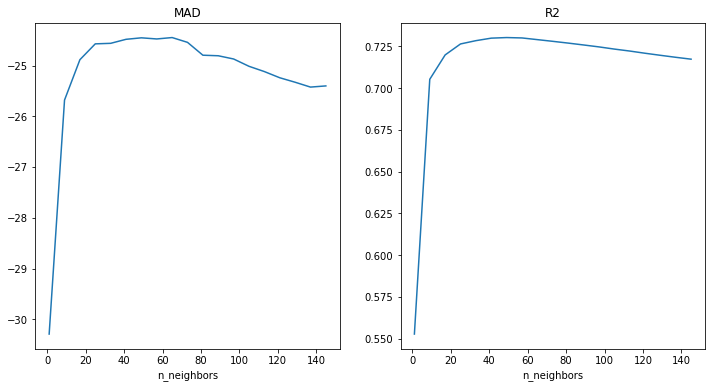

In [23]:
# display CV results
results = grid.cv_results_
print(grid.best_params_)
print(grid.best_score_)

plt.figure(figsize=(12,6))
plt.subplot(121)
iman = results['param_metric'].data=='manhattan'
plt.plot(results['param_n_neighbors'][iman].data , results['mean_test_MAD'][iman])
plt.xlabel('n_neighbors')
plt.title('MAD')
plt.subplot(122)
plt.plot(results['param_n_neighbors'][iman].data , results['mean_test_r2'][iman])
plt.xlabel('n_neighbors')
plt.title('R2')
plt.show()

Observe that the optimal number of neighbors is quite high. This emphasizes that the consumption
time series have a high random variability, which requires a fairly large regularization (averaging over a large neighborhood) in order to improve the accuracy on new data

### Random Forest Regression

In [24]:
from sklearn.ensemble import RandomForestRegressor

# D+1 forecasting with full hourly measurements from one week backward
X = Xa_s
y = ya_target

max_depth = 20
regr_rf = RandomForestRegressor(n_estimators=100, max_depth=max_depth,
                                random_state=0, oob_score=True,
                                verbose=1,
                                criterion='mse', # Rk: too time consumming with the more robust 'mae'
                                n_jobs=-1)
regr_rf.fit(X,y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   26.6s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=True, random_state=0, verbose=1,
                      warm_start=False)

In [25]:
y_rf_a= regr_rf.predict(X)
r2_train = r2_score(y_rf_a,y)
mad_train = median_absolute_error(y_rf_a,y)
print('training error r2 = {}, MAD = {}'.format(r2_train,mad_train) )
print('out of bag score (r2 estimaeted on non used data)= {}'.format(regr_rf.oob_score_))

training error r2 = 0.9683178757223541, MAD = 10.464198878069425
out of bag score (r2 estimaeted on non used data)= 0.8343699000824815


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished


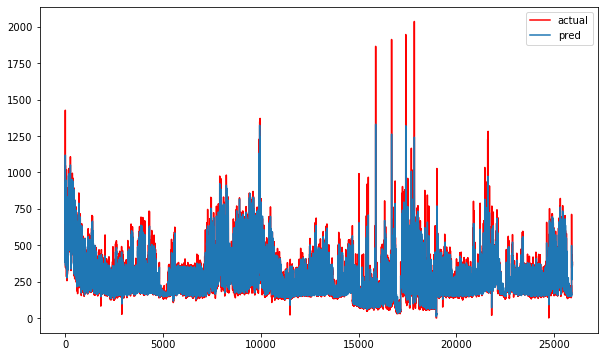

In [26]:
plt.figure(figsize=(10,6))
plt.plot(ya_target.values,'r')
plt.plot(y_rf_a)
plt.legend(['actual','pred'])
plt.show()

**RF gives for free a *score of how the feature* is important**, or **significant**, for the RF regressor
(e.g., from each feature how many times it is used in the decision trees, and how it decreases the variance of the prediction error), 

May be useful to reduce the dimension (variable selection to decrease the number number of features) and to improve the generalization ability

([<matplotlib.axis.XTick at 0x7faa784b7828>,
 <a list of 8 Text xticklabel objects>)

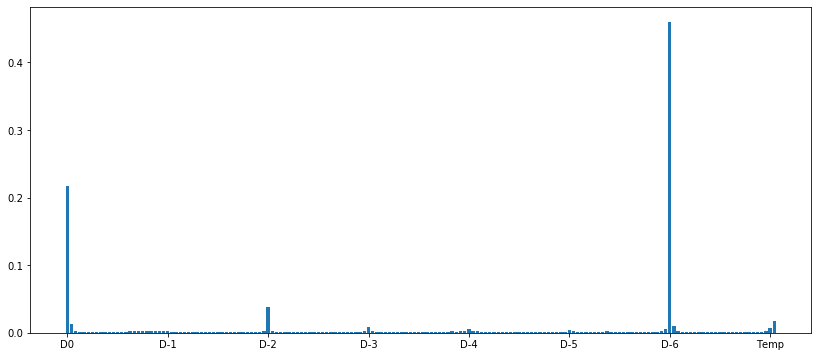

In [27]:
plt.figure(figsize=(14,6))
plt.bar(np.arange(len(regr_rf.feature_importances_)), regr_rf.feature_importances_)
plt.xticks(np.arange(0,24*7+1,24),labels=['D0','D-1','D-2','D-3','D-4','D-5','D-6','Temp'] )

Observe that for the **D+1** forecast, the most important RF features based on the complete hourly measurements of the past week + D0 temperature (last predictor) are in order:
1. consumption at the same time **one week backward** (weekly component)
2. consumption at the same time **one day backward**  (daily component)
3. consumption at the same time several days backward (harmonics of the daily components)
4. temperature

#### Estimate (CV) the test scores for RF

In [28]:
from sklearn.model_selection import cross_validate

groups = np.zeros(y.shape)
years = y.index.year.to_numpy()
for iy , year in enumerate(np.arange( years.min(),  years.max()+1 )):
    gindex = np.where( years == year)[0]
    groups[gindex] = iy
cv = LeaveOneGroupOut()
scoring = {'r2': 'r2', 'MAD': 'neg_median_absolute_error'}
scores = cross_validate(regr_rf, X, y, cv=cv.split(X,y, groups),
                        scoring = scoring)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_job

In [29]:
mad_test = np.mean(scores['test_MAD'])
r2_test = np.mean(scores['test_r2'])        
print('test error r2 = {}, MAD = {}'.format(r2_test,mad_test) )
print('out of bag score (r2 estimaeted on non used data)= {}'.format(regr_rf.oob_score_))

test error r2 = 0.6880225450109158, MAD = -24.730191182901354
out of bag score (r2 estimaeted on non used data)= 0.8343699000824815


observe here that these test error scores are slightly worse than knn with daily predictors